### Imports

In [234]:
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob
import os

from datetime import datetime

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, pos_tag_sents
from nltk.probability import FreqDist
import nltk

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

from yellowbrick.cluster import KElbowVisualizer

from textblob import TextBlob

In [235]:
pd.set_option('max_colwidth', 800)

### Functions

In [236]:
def clean_up(tweet):
    tweet.lower()  #convert the tweet to lower case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)  #convert all urls to string "URL"
    tweet = re.sub('@[^\s]+','AT_USER', tweet) #convert all @username to "AT_USER"
    tweet = re.sub('[\s]+', ' ', tweet)      #correct all multiple white spaces to a single white space
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)   #convert "#topic" to just "topic"
    tweet = re.sub(r'\W*\b\w{1,3}\b', '', tweet)
    tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet)  #remove all ponctuation
    return tweet

def tokenize(s):
    return word_tokenize(s)

def stem_and_lemmatize(l):
    l = ' '.join(l)
    stem = PorterStemmer().stem(l)
    lemm = WordNetLemmatizer().lemmatize(stem)
    return lemm

def remove_stopwords(l):
    languages = ['english',
             'spanish',
             'portuguese',
             'german',
             'french',
             'italian',
             'turkish'
            ]
    stop_words = stopwords.words(languages)
    return [i for i in l.split() if i not in stop_words]

def get_pm(row):
    pms = []
    text = row["text"].lower()
    if "boris" in text or "johnson" in text:
        pms.append("boris")
    elif "theresa" in text:
        pms.append("may")
    else:
        pms.append("none") 
    return ",".join(pms)

### Data

In [237]:
path = r'/Users/ironhack/Documents/GitHub/IronHack/W9FinalProject/final-project/your-project/tweets/2019' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135000 entries, 0 to 134999
Data columns (total 15 columns):
username          135000 non-null object
to                85451 non-null object
text              134606 non-null object
retweets          135000 non-null int64
favorites         135000 non-null int64
replies           135000 non-null int64
id                135000 non-null int64
permalink         135000 non-null object
author_id         135000 non-null int64
date              135000 non-null object
formatted_date    135000 non-null object
hashtags          30722 non-null object
mentions          18084 non-null object
geo               0 non-null float64
urls              41042 non-null object
dtypes: float64(1), int64(5), object(9)
memory usage: 15.4+ MB


In [239]:
df.isna().sum()*100/len(df)

username            0.000000
to                 36.702963
text                0.291852
retweets            0.000000
favorites           0.000000
replies             0.000000
id                  0.000000
permalink           0.000000
author_id           0.000000
date                0.000000
formatted_date      0.000000
hashtags           77.242963
mentions           86.604444
geo               100.000000
urls               69.598519
dtype: float64

In [240]:
df.columns

Index(['username', 'to', 'text', 'retweets', 'favorites', 'replies', 'id',
       'permalink', 'author_id', 'date', 'formatted_date', 'hashtags',
       'mentions', 'geo', 'urls'],
      dtype='object')

In [241]:
df = df[['date','id', 'username', 'text']]

In [242]:
df.head()

,date,id,username,text
0,2019-07-30 23:59:58+00:00,1156353776049111040,janekin24,Not about Brexit for Boris. I see his strategy. It’s all about killing off TBP. Smokescreen of WTO hard talk.Then he will give us Brino. Well Twitter friends. Are we going to let him get away with this or will we take TBP all the way to government? We are not going into that box!
1,2019-07-30 23:59:58+00:00,1156353774262390785,brexit_clock,"WOW - Another Brexit extension - time now until 31st October 2019 : 92 days, 21 hours, 59 minutes and 59 seconds #BREXIT #BREXITCLOCK #CLOCK #EU #EUREF #LEAVE"
2,2019-07-30 23:59:50+00:00,1156353739437019136,JuanWild51,Brexit: Can Anyone Take the Wheel From Johnson?..#Bojo..#Brexit..#Britain..
3,2019-07-30 23:59:45+00:00,1156353717987368960,DGAll41,"Brexit minister Stephen Barclay tells Michel Barnier that UK will leave EU on October 31 with or without a deal - Evening Standard. Amazing Gove has just been bollocked for similar terminology and less than 24 hrs later, dick Barclay blunders in."
4,2019-07-30 23:59:44+00:00,1156353717232459776,BioMickWatson,This isn't a superhero movie where the bad guy gets to be a good guy because they share common cause. Brexit and Scottish indy *are* the common cause we need to fight against


In [243]:
df.dropna(inplace=True)

In [244]:
df.dtypes

date        object
id           int64
username    object
text        object
dtype: object

In [245]:
df[df.duplicated()]

,date,id,username,text


In [246]:
df.drop('id', inplace=True, axis=1)

### Fixing time type column

In [247]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = [d.date() for d in df['date']]

### Creating column for Theresa May/Boris Jonhson - selecting tweets that only refer the PMs

In [248]:
df["pm"] = df.apply(get_pm,axis=1)

In [249]:
#le = preprocessing.LabelEncoder()
#df["pm_label"] = le.fit_transform(df.pm.values)

In [250]:
df["pm"].value_counts()

none     113240
boris     13471
may        7895
Name: pm, dtype: int64

In [251]:
may_df = df[df['pm'] == 'may']
boris_df = df[df['pm'] == 'boris']
df_mb = may_df.append(boris_df)

### Cleaning the tweets

In [252]:
df_mb['text_wturls'] = df_mb['text'].apply(clean_up)

In [253]:
df_mb['text_processed'] = df_mb['text'].apply(clean_up).apply(tokenize).apply(stem_and_lemmatize)\
                       .apply(remove_stopwords)

In [254]:
df_mb['clean_text'] = [' '.join(map(str, l)) for l in df_mb['text_processed']]

### Making tags for May

In [137]:
df_mb['POSTags'] = pos_tag_sents(df_mb['clean_text'].apply(word_tokenize).tolist())

In [255]:
df_mb = df_mb[['date','text','text_wturls','text_processed','clean_text','pm']]

In [256]:
df_mb

,date,text,text_wturls,text_processed,clean_text,pm
287,2019-07-30,"Theresa May was not highly rated by her colleagues or the civil service, even before she became PM. But on top of that, she supported Remain in the referendum. Therefore she always regarded #Brexit as a damage limitation exercise, rather than a golden opportunity for the UK.",Theresa highly rated colleagues civil service even before became that supported Remain referendum Therefore always regarded Brexit damage limitation exercise rather than golden opportunity,"[theresa, highly, rated, colleagues, civil, service, even, became, supported, remain, referendum, therefore, always, regarded, brexit, damage, limitation, exercise, rather, golden, opportun]",theresa highly rated colleagues civil service even became supported remain referendum therefore always regarded brexit damage limitation exercise rather golden opportun,may
621,2019-07-30,Theresa May MP: Give People a Final Say on Brexit Deal - Sign the Petition! http://chng.it/V2hMq75D via @UKChange,Theresa Give People Final Brexit Deal Sign Petition AT USER,"[theresa, give, people, final, brexit, deal, sign, petition, us]",theresa give people final brexit deal sign petition us,may
1033,2019-07-30,Brexit Flextension Will Be Extended Forevextension in Permaextension Brexitstension https://www.dailysquib.co.uk/world/31578-brexit-flextension-will-be-extended-forevextension-in-permaextension-brexitstention.html #brexit #theresamay,Brexit Flextension Will Extended Forevextension Permaextension Brexitstension brexit theresamay,"[brexit, flextension, extended, forevextension, permaextension, brexitstension, brexit, theresamay]",brexit flextension extended forevextension permaextension brexitstension brexit theresamay,may
1110,2019-07-30,"#Brexit Delay #TheresaMay Consulted by Peter Mandelson, David Cameron &amp; Tony Blair https://www.dailysquib.co.uk/world/20666-theresa-may-consulted-peter-mandelson-david-cameron-tony-blair.html",Brexit Delay TheresaMay Consulted Peter Mandelson David Cameron Tony Blair,"[brexit, delay, theresamay, consulted, peter, mandelson, david, cameron, tony, blair]",brexit delay theresamay consulted peter mandelson david cameron tony blair,may
1357,2019-07-30,Very interesting documentary last week describing how Theresa May came to realise the genuine threat to the Union caused by a no deal Brexit.,Very interesting documentary last week describing Theresa came realise genuine threat Union caused deal Brexit,"[interesting, documentary, last, week, describing, theresa, came, realise, genuine, threat, union, caused, deal, brexit]",interesting documentary last week describing theresa came realise genuine threat union caused deal brexit,may
...,...,...,...,...,...,...
134943,2020-02-12,"@BorisJohnson, racists, andfar right @Conservatives got #Brexit, because they want to close the borders and don't have a plan to protect the economy which will hurt the country. #BrexitRacism #DissolveTheUnion #BrexitShambles #BrexitLies #Antifascism #Antiracism #BorisTheLiar",AT USER racists andfar right AT USER Brexit because they want close borders have plan protect economy which will hurt country BrexitRacism DissolveTheUnion BrexitShambles BrexitLies Antifascism Antiracism BorisTheLiar,"[user, racists, andfar, right, user, brexit, want, close, borders, plan, protect, economy, hurt, country, brexitracism, dissolvetheunion, brexitshambles, brexitlies, antifascism, antiracism, boristheliar]",user racists andfar right user brexit want close borders plan protect economy hurt country brexitracism dissolvetheunion brexitshambles brexitlies antifascism antiracism boristheliar,boris
134947,2020-02-12,The Guardian view on Boris Johnson in court: Brexit’s war on the law,Guardian view Boris Johnson court Brexit,"[guardian, view, boris, johnson, court, brexit]",guardian view boris johnson court brexit,boris
134958,2020-02-12,The Guardian view on Boris Johnson in court: Brexit’s war on the law https://www.plow.io/post/the-guar

### Checking top words

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 50')

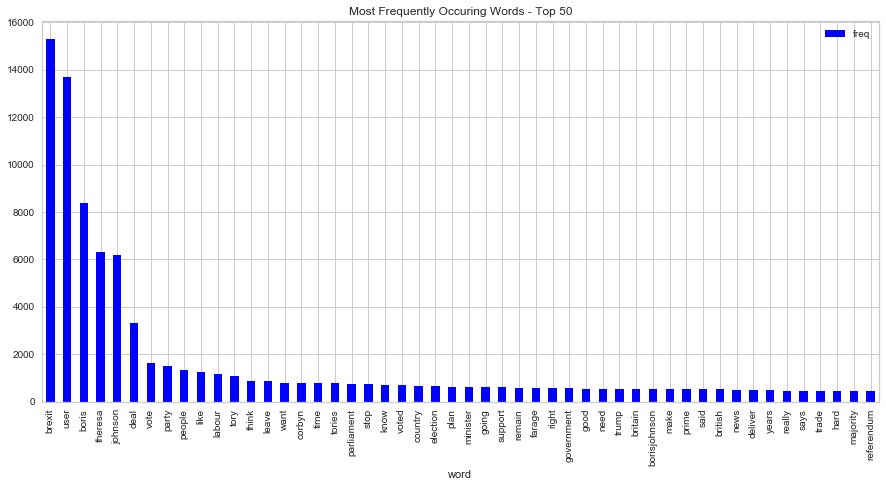

In [178]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_mb['clean_text'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 50")

In [179]:
frequency.head(50)

,word,freq
0,brexit,15290
1,user,13704
2,boris,8357
3,theresa,6301
4,johnson,6202
5,deal,3309
6,vote,1607
7,party,1501
8,people,1352
9,like,1263


## K-means

### Checking optimal number of clusters

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10,random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,17))
visualizer.fit(X3)
visualizer.poof()

### Preparing & Implementing K-Means

In [ ]:
# vectorizing
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(df['text'])
desc_matrix = tf_idf_vect.transform(df["text"])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

In [ ]:
# implementing kmeans
km = KMeans(n_clusters = 3, n_init = 10, n_jobs = -1)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [ ]:
df['labels'] = clusters

### Checking results

#### 3 iterations

In [ ]:
df[df['pm'] == 'may']['labels'].value_counts()

In [ ]:
df[df['pm'] == 'boris']['labels'].value_counts()

#### 10 iterations

In [ ]:
df[df['pm'] == 'may']['labels'].value_counts()

In [ ]:
df[df['pm'] == 'boris']['labels'].value_counts()

## Evaluating model

In [ ]:
preds = cluster.fit_predict(features)
centers = cluster.cluster_centers_

score = silhouette_score (features, preds, metric='euclidean')
print (f"For n_clusters = {n_clusters}, silhouette score is {score})")

## try to plot to see what it looks like

## Sentiment Analysis

### NLKT

In [257]:
#with nlkt sentiment analysys
sid = SentimentIntensityAnalyzer()

df_mb['sentiment_compound_polarity'] = df_mb['clean_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_mb['sentiment_neutral'] = df_mb['clean_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
df_mb['sentiment_negative'] = df_mb['clean_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
df_mb['sentiment_pos'] = df_mb['clean_text'].apply(lambda x:sid.polarity_scores(x)['pos'])

df_mb.loc[df_mb.sentiment_compound_polarity > 0,'sentiment'] = 'positive'
df_mb.loc[df_mb.sentiment_compound_polarity == 0,'sentiment'] = 'neutral'
df_mb.loc[df_mb.sentiment_compound_polarity < 0,'sentiment'] = 'negative'
df_mb.head()

,date,text,text_wturls,text_processed,clean_text,pm,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment
287,2019-07-30,"Theresa May was not highly rated by her colleagues or the civil service, even before she became PM. But on top of that, she supported Remain in the referendum. Therefore she always regarded #Brexit as a damage limitation exercise, rather than a golden opportunity for the UK.",Theresa highly rated colleagues civil service even before became that supported Remain referendum Therefore always regarded Brexit damage limitation exercise rather than golden opportunity,"[theresa, highly, rated, colleagues, civil, service, even, became, supported, remain, referendum, therefore, always, regarded, brexit, damage, limitation, exercise, rather, golden, opportun]",theresa highly rated colleagues civil service even became supported remain referendum therefore always regarded brexit damage limitation exercise rather golden opportun,may,-0.4767,0.700,0.210,0.089,negative
621,2019-07-30,Theresa May MP: Give People a Final Say on Brexit Deal - Sign the Petition! http://chng.it/V2hMq75D via @UKChange,Theresa Give People Final Brexit Deal Sign Petition AT USER,"[theresa, give, people, final, brexit, deal, sign, petition, us]",theresa give people final brexit deal sign petition us,may,0.0000,1.000,0.000,0.000,neutral
1033,2019-07-30,Brexit Flextension Will Be Extended Forevextension in Permaextension Brexitstension https://www.dailysquib.co.uk/world/31578-brexit-flextension-will-be-extended-forevextension-in-permaextension-brexitstention.html #brexit #theresamay,Brexit Flextension Will Extended Forevextension Permaextension Brexitstension brexit theresamay,"[brexit, flextension, extended, forevextension, permaextension, brexitstension, brexit, theresamay]",brexit flextension extended forevextension permaextension brexitstension brexit theresamay,may,0.0000,1.000,0.000,0.000,neutral
1110,2019-07-30,"#Brexit Delay #TheresaMay Consulted by Peter Mandelson, David Cameron &amp; Tony Blair https://www.dailysquib.co.uk/world/20666-theresa-may-consulted-peter-mandelson-david-cameron-tony-blair.html",Brexit Delay TheresaMay Consulted Peter Mandelson David Cameron Tony Blair,"[brexit, delay, theresamay, consulted, peter, mandelson, david, cameron, tony, blair]",brexit delay theresamay consulted peter mandelson david cameron tony blair,may,-0.3182,0.796,0.204,0.000,negative
1357,2019-07-30,Very interesting documentary last week describing how Theresa May came to realise the genuine threat to the Union caused by a no deal Brexit.,Very interesting documentary last week describing Theresa came realise genuine threat Union caused deal Brexit,"[interesting, documentary, last, week, describing, theresa, came, realise, genuine, threat, union, caused, deal, brexit]",interesting documentary last week describing theresa came realise genuine threat union caused deal brexit,may,-0.1779,0.663,0.188,0.149,negative


In [30]:
#df_mb.drop(['sentiment_polarity', 'sentiment_type','sentiment_neutral', 'sentiment_negative', 'sentiment_pos', 'sentiment_compound_polarity'], axis=1, inplace=True)

In [258]:
df_mb.groupby('pm')['sentiment'].value_counts()

pm     sentiment
boris  positive     5167
       negative     5012
       neutral      3292
may    positive     3190
       negative     2570
       neutral      2135
Name: sentiment, dtype: int64

### Textblob

In [ ]:
#polarity = lambda x: TextBlob(x).sentiment.polarity
#subjectivity = lambda x: TextBlob(x).sentiment.subjectivity
#df_mb['polarity_blob'] = df_mb['clean_text'].apply(polarity)
#df_mb['subjectivity_blob'] = df_mb['clean_text'].apply(subjectivity)

#df_mb.loc[df_mb.polarity_blob >= 1,'sentiment_blob'] = 'positive'
#df_mb.loc[df_mb.polarity_blob == 0,'sentiment_blob'] = 'neutral'
#df_mb.loc[df_mb.polarity_blob <= 1,'sentiment_blob'] = 'negative'

#df_mb.head()

In [76]:
#with textblob sentiment analysys
sentiments_textblob = df_mb['clean_text'].apply(lambda tweet: sentiment_textblob(tweet))
pd.DataFrame(sentiments_textblob.value_counts())

,clean_text
positive,16657
negative,4709
